In [1]:
# 미래에 python3로의 호환성 확보를 위함
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# 압축 풀고, 파일을 다루고, 시간을 재고, ...
import gzip
import os
import sys
import time

# 그림/그래프 출력
%matplotlib inline
import matplotlib.pyplot as plt

import numpy
import tensorflow as tf

In [2]:
WORK_DIRECTORY = 'data'
IMAGE_SIZE = 28  # MNIST는 28x28 흑백 이미지
NUM_CHANNELS = 1
PIXEL_DEPTH = 255
NUM_LABELS = 10
VALIDATION_SIZE = 5000  # 밸리데이션셋 크기, 6만장 중 5천장을 떼어내서 밸리데이션셋으로 쓴다.
                        # 테스트셋은 별도로 1만장이 존재한다. 혼동하지 말자!

In [3]:
# data/에 저장되어 있는 데이터 파일 이름
train_data_filename = 'train-images-idx3-ubyte.gz'
train_labels_filename ='train-labels-idx1-ubyte.gz'
test_data_filename = 't10k-images-idx3-ubyte.gz'
test_labels_filename = 't10k-labels-idx1-ubyte.gz'

In [4]:
def extract_data(filename, num_images):
  """압축된 데이터 파일에서 image를 추출해서 4D 텐서로 만들어준다. [image index, y, x, channels]
     픽셀값은 [0, 255] 에서 [-0.5, 0.5]로 rescale 해준다."""
  print('Extracting', filename)
  with gzip.open(WORK_DIRECTORY+'/'+filename) as bytestream:
    bytestream.read(16)
    buf = bytestream.read(IMAGE_SIZE * IMAGE_SIZE * num_images * NUM_CHANNELS)
    data = numpy.frombuffer(buf, dtype=numpy.uint8).astype(numpy.float32)
    data = (data - (PIXEL_DEPTH / 2.0)) / PIXEL_DEPTH
    data = data.reshape(num_images, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS)
    return data

In [5]:
def extract_labels(filename, num_images):
  """데이터 레이블(0~9)를 추출해서 int64의 벡터로 만들어준다."""
  print('Extracting', filename)
  with gzip.open(WORK_DIRECTORY+'/'+filename) as bytestream:
    bytestream.read(8)
    buf = bytestream.read(1 * num_images)
    labels = numpy.frombuffer(buf, dtype=numpy.uint8).astype(numpy.int64)
  return labels

In [6]:
# 데이터와 레이블을 numpy array로 읽어들임
train_data = extract_data(train_data_filename, 60000)
train_labels = extract_labels(train_labels_filename, 60000)
test_data = extract_data(test_data_filename, 10000)
test_labels = extract_labels(test_labels_filename, 10000)

Extracting train-images-idx3-ubyte.gz
Extracting train-labels-idx1-ubyte.gz
Extracting t10k-images-idx3-ubyte.gz
Extracting t10k-labels-idx1-ubyte.gz


(60000, 28, 28, 1) (60000,)
(10000, 28, 28, 1) (10000,)
0


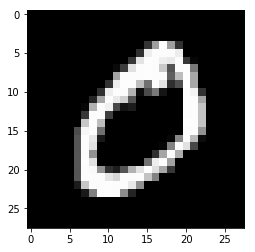

In [7]:
print(train_data.shape,train_labels.shape)
print(test_data.shape,test_labels.shape)
print(train_labels[1])
plt.imshow(train_data[1].reshape(28,28), cmap='gray', interpolation='none')

In [8]:
# 훈련셋 중 일부를 떼어 밸리데이션셋을 만든다.
validation_data = train_data[:VALIDATION_SIZE, ...]
validation_labels = train_labels[:VALIDATION_SIZE]
train_data = train_data[VALIDATION_SIZE:, ...]
train_labels = train_labels[VALIDATION_SIZE:]

print(validation_data.shape, validation_labels.shape, train_data.shape, train_labels.shape, test_data.shape, test_labels.shape)

(5000, 28, 28, 1) (5000,) (55000, 28, 28, 1) (55000,) (10000, 28, 28, 1) (10000,)


LeNet-5는 3개의 convolutional layer, (2개의 pooling layer), 2개의 fully-connected로 이루어져 있습니다.

각 convolutional layer와 fully-connected layer에서 사용할 weight와 bias를 선언해봅시다.

여기서 선언한 Variable은 이후 tf.global_variables_initializer().run()을 호출하여 초기화하면 됩니다.

참고로, LeNet-5의 구조는 아래와 같습니다.

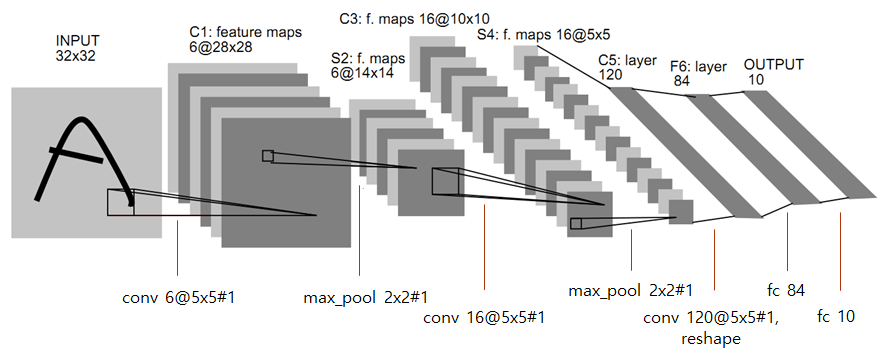

In [ ]:
# 아래에 convolutional layer와 fully-connected layer에서 사용할 패러미터를 선언해봅시다.
# - LeNet-5에서 trainable weights는 3개의 conv layer와 2개의 fully connected layer만 가지고 있습니다.
# - 각 layer의 차원에 맞는 weight와 bias를 선언해줘야 합니다.







네트워크에서 사용할 패러미터를 다 선언하고 나면 이제 네트워크 모델을 구성해줄 차례입니다.

아래에 모델을 구성해봅시다.

- 데이터 및 레이블을 feed해주기 위한 placeholder
- convolution, activation, pooling, convolution, activation, pooling, convolution, reshape, FC, FC 순
- original LeNet-5는 activation function으로 tanh를 사용
- 각 layer간 결과 feature의 dimension을 확인하기 위해서는 print(레이어변수명.get_shape().as_list()) 함수를 사용

In [ ]:
# 여기에 모델을 정의해봅시다.








데이터 준비, 패러미터 준비, 모델 구성까지 다 하고 나면, 이제 모델을 학습시켜야 합니다.

모델을 학습시키기 위해서는 몇 가지 준비가 필요합니다.

- 학습을 위한 loss function과 나중에 네트워크를 사용 또는 평가하기 위한 prediction단(보통 softmax)를 네트워크에 추가
- error rate 계산 함수 : 이번 실습에서는 단순히 아래 지정한 정답율 계산 함수를 사용
- Optimizer.minimize 함수를 네트워크에 추가. 여기서는 tf.train.GradientDescentOptimizer를 사용해봅시다. (https://www.tensorflow.org/api_docs/python/tf/train/GradientDescentOptimizer)
- learning rate 업데이트 방법에는 다양한 방법이 있으나, 여기에서는 exponential decay를 먼저 시도해봅시다. (https://www.tensorflow.org/api_docs/python/tf/train/exponential_decay)

In [ ]:
# loss 및 prediction 노드를 네트워크에 추가합시다.
# - loss 노드는 tf.reduce_mean, tf.nn.sparse_softmax_cross_entropy_with_logits 함수를 이용
# - prediction 노드는 tf.nn.softmax 함수를 이용








In [9]:
# 정답율 계산 함수
def error_rate(predictions, labels):
  """예측한 결과들과 레이블들을 가지고 에러율을 계산하는 함수.
     argmax는 것은 벡터에서 가장 큰 엘리먼트의 인덱스를 리턴."""
  return 100.0 - (
      100.0 *
      numpy.sum(numpy.argmax(predictions, axis=1) == labels) /
      predictions.shape[0])

In [ ]:
# learning rate 선언 및 Optimizer 선언
# - learning rate의 exponential decay는 tf.train.exponential_decay 함수를 이용
# - SGD는 tf.train.GradientDescentOptimizer를 이용






준비가 다 되었으면, session을 생성하고 .run() 함수를 호출하여 학습을 진행합니다.

학습은 아래와 같은 순서로 진행합니다.

1. session 생성 (tf.Session)
2. variable 초기화 (tf.global_variables_initializer)
3. loop를 돌리면서 각 minibatch 단위로 입력 데이터의 feed를 준비하고, sess.run(fetches, feed_dict)을 실행
4. (적당한 간격마다 밸리데이션 데이터 중 일부를 가지고 prediction을 수행하여 에러율을 계산, 학습 loss 및 에러율을 출력
5. 학습이 완료되면 테스트 데이터를 먹여 prediction을 수행하고 에러율을 계산

In [ ]:
# 아래에 학습을 수행하고 결과를 출력하는 코드를 작성해봅시다.








(추가연습) LeNet-5의 성능을 개선해봅시다.
1. activation function 변경 (tf.sigmoid, tf.nn.relu)
2. l2_regularization 추가 (tf.nn.l2_loss)
3. optimizer 변경 등 (참조: https://www.tensorflow.org/api_guides/python/train#Optimizers)